<a href="https://colab.research.google.com/github/iamsusiep/tumor_challenge/blob/master/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
!pip install -q tensorflow-gpu==2.0.0-alpha0

Sun May 19 21:10:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.color import rgb2gray
import os
from os import listdir
from os.path import isfile, join
import random 
import cv2
from sklearn.preprocessing import normalize
from google.cloud import bigquery
from google.colab import auth
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Activation, Input, concatenate

## Mount Drive for Data


In [3]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/Colab Notebooks/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### UNZIP THE DATA IF IN ZIP FORMAT

In [0]:
# data = "."
# data_zip = "./data_zoom.zip"
# zip_ref = zipfile.ZipFile(data_zip, "r")
# zip_ref.extractall(data)
# zip_ref.close()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from keras.utils import *

TARGET_SHAPE = 299 
BATCH_SIZE = 32

def get_image_gen(level):
    train_dir = 'data/train/z{}'.format(level)
    val_dir = 'data/val/z{}'.format(level)
    print('Train dir: ', train_dir)
    print('Val dir: ', val_dir)

    image_gen_train = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip=True,
                                         vertical_flip=True)
#                                          rotation_range=90)
    image_gen_val = ImageDataGenerator(rescale=1./255)

    train_data_gen = image_gen_train.flow_from_directory(
        batch_size=BATCH_SIZE,
        directory=train_dir,
        shuffle=True,
        target_size=(TARGET_SHAPE,TARGET_SHAPE),
        class_mode='binary')

    # Validation data should not be augmented!
    val_data_gen = image_gen_val.flow_from_directory(
        batch_size=BATCH_SIZE, 
        directory=val_dir, 
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        class_mode='binary')

    weights = class_weight.compute_class_weight('balanced',
                                                np.unique(train_data_gen.classes), 
                                                train_data_gen.classes)
    return train_data_gen, val_data_gen, {0: weights[0], 1: weights[1]}

Using TensorFlow backend.


# Zoom Level 2

In [0]:
!pwd
print('Num tumor: ')
!find data/train/z2/tumor -type f | grep jpg | wc -l
print('Num non-tumor: ')
!find data/train/z2/no_tumor -type f | grep jpg | wc -l

/content/gdrive/My Drive/Colab Notebooks
Num tumor: 
find: ‘data/train/z2/tumor’: No such file or directory
0
Num non-tumor: 
find: ‘data/train/z2/no_tumor’: No such file or directory
0


In [0]:
train_data_gen_z2, val_data_gen_z2, class_weights_z2 = get_image_gen(2)

Train dir:  data/train/z2
Val dir:  data/val/z2
Found 200 images belonging to 2 classes.
Found 144 images belonging to 2 classes.


In [0]:
total_train_z2 = train_data_gen_z2.n
total_val_z2 = val_data_gen_z2.n

### Balancing data with Class Weighting

In [0]:
print(class_weights_z2)
print('Percent no tumor for Training: {}'.format((np.bincount(train_data_gen_z2.classes)/train_data_gen_z2.n)[0]))
print('Percent no tumor for Validation: {}'.format((np.bincount(val_data_gen_z2.classes)/val_data_gen_z2.n)[0]))

{0: 2.0, 1: 0.6666666666666666}
Percent no tumor for Training: 0.25
Percent no tumor for Validation: 0.2777777777777778


### Pre-trained Inception Model

In [0]:
conv_base1 = InceptionV3(weights='imagenet',include_top=False, input_shape=(299, 299, 3))
conv_base1.trainable = False

model_z2 = Sequential()
model_z2.add(conv_base1)
model_z2.add(Flatten())
model_z2.add(Dense(32, activation='relu'))
model_z2.add(Dense(1, activation='sigmoid'))
model_z2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4194336   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 25,997,153
Trainable params: 4,194,369
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
EPOCHS = 20

model_z2.compile(loss='binary_crossentropy', 
                 optimizer='adam', 
                 metrics=['acc'])

# Now is a good time for a cup of coffee
history_z2 = model_z2.fit_generator(
      train_data_gen_z2,
      steps_per_epoch=int(np.ceil(total_train_z2 / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen_z2,
      validation_steps=int(np.ceil(total_val_z2 / float(BATCH_SIZE))),
#       class_weight=class_weights_z2,
      verbose=2)

Epoch 1/20
7/7 - 142s - loss: 7.6679 - acc: 0.6350 - val_loss: 0.6933 - val_acc: 0.2778
Epoch 2/20
7/7 - 2s - loss: 0.6932 - acc: 0.4500 - val_loss: 0.6928 - val_acc: 0.7222
Epoch 3/20
7/7 - 2s - loss: 0.6923 - acc: 0.7500 - val_loss: 0.6916 - val_acc: 0.7222
Epoch 4/20
7/7 - 2s - loss: 0.6908 - acc: 0.7500 - val_loss: 0.6904 - val_acc: 0.7222
Epoch 5/20
7/7 - 2s - loss: 0.6896 - acc: 0.7500 - val_loss: 0.6891 - val_acc: 0.7222
Epoch 6/20
7/7 - 2s - loss: 0.6873 - acc: 0.7500 - val_loss: 0.6877 - val_acc: 0.7222
Epoch 7/20
7/7 - 2s - loss: 0.6862 - acc: 0.7500 - val_loss: 0.6859 - val_acc: 0.7222
Epoch 8/20
7/7 - 2s - loss: 0.6846 - acc: 0.7500 - val_loss: 0.6847 - val_acc: 0.7222
Epoch 9/20
7/7 - 2s - loss: 0.6833 - acc: 0.7550 - val_loss: 0.6840 - val_acc: 0.7222
Epoch 10/20
7/7 - 2s - loss: 0.6780 - acc: 0.7550 - val_loss: 0.6823 - val_acc: 0.7222
Epoch 11/20
7/7 - 2s - loss: 0.6807 - acc: 0.7500 - val_loss: 0.6810 - val_acc: 0.7222
Epoch 12/20
7/7 - 2s - loss: 0.6690 - acc: 0.7650 

In [0]:
from sklearn.metrics import classification_report

preds = model_z2.predict_generator(val_data_gen_z2, steps = np.ceil(val_data_gen_z2.samples/val_data_gen_z2.batch_size))
pred_class = np.argmax(preds, axis = 1)
true_classes = val_data_gen_z2.classes
class_labels = list(val_data_gen_z2.class_indices.keys())
report = classification_report(true_classes, pred_class, target_names = class_labels)
print(report)

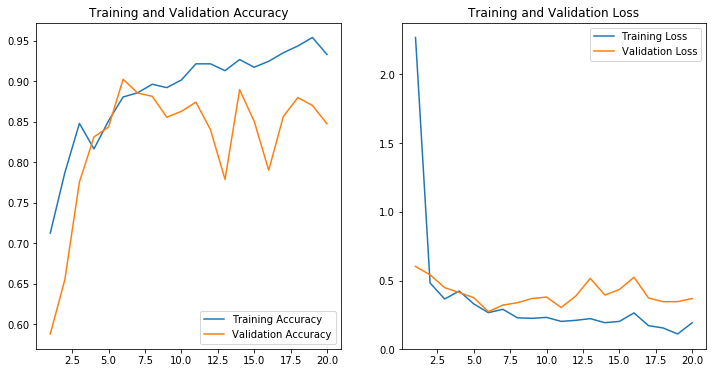

In [0]:
acc = history_z2.history['acc']
val_acc = history_z2.history['val_acc']

loss = history_z2.history['loss']
val_loss = history_z2.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# save model and history object
import json

model_z2.save('/content/gdrive/My Drive/Colab Notebooks/z2_inception_20_epoch.h5')
history_z2_dict = history_z2.history
with open('z2_inception_20_epoch_history.txt', 'w') as outfile:  
    json.dump(str(history_z2_dict), outfile)

### Own Model

In [0]:
my_model_z2 = Sequential()
my_model_z2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
my_model_z2.add(MaxPooling2D((2, 2)))
my_model_z2.add(Conv2D(64, (3, 3), activation='relu'))
my_model_z2.add(MaxPooling2D((2, 2)))
my_model_z2.add(Conv2D(128, (3, 3), activation='relu'))
my_model_z2.add(MaxPooling2D((2, 2)))
my_model_z2.add(Conv2D(128, (3, 3), activation='relu'))
my_model_z2.add(MaxPooling2D((2, 2)))
my_model_z2.add(Flatten())
my_model_z2.add(Dense(128, activation='relu'))
my_model_z2.add(Dropout(0.25))
my_model_z2.add(Dense(128, activation='relu'))
# my_model_z2.add(Dense(512, activation='relu'))
my_model_z2.add(Dense(1, activation='sigmoid'))
my_model_z2.summary()

# my_model_z2 = Sequential() 
# my_model_z2.add(Conv2D(filters=64, kernel_size=2, activation='relu', input_shape=(299, 299, 3)))
# my_model_z2.add(MaxPooling2D(pool_size=2))
# my_model_z2.add(Dropout(0.3))
# my_model_z2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# my_model_z2.add(MaxPooling2D(pool_size=2))
# my_model_z2.add(Dropout(0.3))
# my_model_z2.add(Flatten())
# my_model_z2.add(Dense(256, activation='relu'))
# my_model_z2.add(Dropout(0.5))
# my_model_z2.add(Dense(2, activation='softmax'))
# my_model_z2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       1

In [0]:
EPOCHS = 15

my_model_z2.compile(loss='binary_crossentropy', 
                    optimizer='adam', 
                    metrics=['acc'])

# Now is a good time for a cup of coffee
my_history_z2 = my_model_z2.fit_generator(
      train_data_gen_z2,
      steps_per_epoch=int(np.ceil(total_train_z2 / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen_z2,
      validation_steps=int(np.ceil(total_val_z2 / float(BATCH_SIZE))),
#       class_weight=class_weights_z2,
      verbose=2)

Epoch 1/15
30/30 - 856s - loss: 0.6594 - acc: 0.6422 - val_loss: 0.5033 - val_acc: 0.6858
Epoch 2/15
30/30 - 10s - loss: 0.5212 - acc: 0.7492 - val_loss: 0.3439 - val_acc: 0.8045
Epoch 3/15
30/30 - 10s - loss: 0.4735 - acc: 0.7954 - val_loss: 0.4055 - val_acc: 0.7819
Epoch 4/15
30/30 - 10s - loss: 0.3845 - acc: 0.8332 - val_loss: 0.2185 - val_acc: 0.9467
Epoch 5/15
30/30 - 10s - loss: 0.3506 - acc: 0.8688 - val_loss: 0.2715 - val_acc: 0.8619
Epoch 6/15
30/30 - 10s - loss: 0.3137 - acc: 0.8730 - val_loss: 0.6859 - val_acc: 0.6438
Epoch 7/15
30/30 - 10s - loss: 0.3174 - acc: 0.8741 - val_loss: 0.3246 - val_acc: 0.8263
Epoch 8/15
30/30 - 10s - loss: 0.2862 - acc: 0.8867 - val_loss: 0.1431 - val_acc: 0.9742
Epoch 9/15
30/30 - 11s - loss: 0.4876 - acc: 0.7870 - val_loss: 0.5457 - val_acc: 0.6777
Epoch 10/15
30/30 - 11s - loss: 0.3744 - acc: 0.8468 - val_loss: 0.2251 - val_acc: 0.9136
Epoch 11/15
30/30 - 10s - loss: 0.3120 - acc: 0.8709 - val_loss: 0.2204 - val_acc: 0.8885
Epoch 12/15
30/30 

In [0]:
from sklearn.metrics import classification_report

preds = my_model_z2.predict_generator(val_data_gen_z2, steps = np.ceil(val_data_gen_z2.samples/val_data_gen_z2.batch_size))
pred_class = np.argmax(preds, axis = 1)
true_classes = val_data_gen_z2.classes
class_labels = list(val_data_gen_z2.class_indices.keys())
report = classification_report(true_classes, pred_class, target_names = class_labels)
print(report)

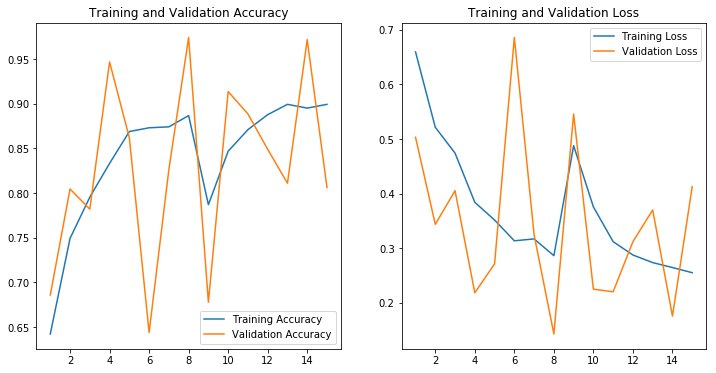

In [0]:
acc = my_history_z2.history['acc']
val_acc = my_history_z2.history['val_acc']

loss = my_history_z2.history['loss']
val_loss = my_history_z2.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# save model and history object
import json

my_model_z2.save('/content/gdrive/My Drive/Colab Notebooks/z2_custom_15_epoch.h5')
my_history_z2_dict = my_history_z2.history
with open('z2_custom_15_epoch_history.txt', 'w') as outfile:  
    json.dump(str(my_history_z2_dict), outfile)

# Zoom Level 3

In [29]:
train_data_gen_z3, val_data_gen_z3, class_weights_z3 = get_image_gen(3)

total_train_z3 = train_data_gen_z3.n
total_val_z3 = val_data_gen_z3.n

Train dir:  data/train/z3
Val dir:  data/val/z3
Found 2308 images belonging to 2 classes.
Found 581 images belonging to 2 classes.


In [0]:
my_model_z3 = Sequential()
my_model_z3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
my_model_z3.add(MaxPooling2D((2, 2)))
my_model_z3.add(Conv2D(64, (3, 3), activation='relu'))
my_model_z3.add(MaxPooling2D((2, 2)))
my_model_z3.add(Conv2D(128, (3, 3), activation='relu'))
my_model_z3.add(MaxPooling2D((2, 2)))
my_model_z3.add(Conv2D(128, (3, 3), activation='relu'))
my_model_z3.add(MaxPooling2D((2, 2)))
my_model_z3.add(Flatten())
# my_model_z3.add(Dense(512, activation='relu'))
my_model_z3.add(Dense(1, activation='sigmoid'))

In [31]:
EPOCHS = 15

my_model_z3.compile(loss='binary_crossentropy', 
                    optimizer='adam', 
                    metrics=['acc'])

# Now is a good time for a cup of coffee
my_history_z3 = my_model_z3.fit_generator(
      train_data_gen_z3,
      steps_per_epoch=int(np.ceil(total_train_z3 / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen_z3,
      validation_steps=int(np.ceil(total_val_z3 / float(BATCH_SIZE))),
#       class_weight=class_weights_z3,
      verbose=2)

Epoch 1/15
73/73 - 864s - loss: 0.5600 - acc: 0.7197 - val_loss: 0.2670 - val_acc: 0.9260
Epoch 2/15
73/73 - 15s - loss: 0.4288 - acc: 0.8146 - val_loss: 0.2956 - val_acc: 0.9071
Epoch 3/15
73/73 - 14s - loss: 0.3977 - acc: 0.8297 - val_loss: 0.2093 - val_acc: 0.9380
Epoch 4/15
73/73 - 13s - loss: 0.3741 - acc: 0.8479 - val_loss: 0.2301 - val_acc: 0.9363
Epoch 5/15
73/73 - 14s - loss: 0.3689 - acc: 0.8432 - val_loss: 0.2211 - val_acc: 0.9398
Epoch 6/15
73/73 - 14s - loss: 0.3728 - acc: 0.8583 - val_loss: 0.2851 - val_acc: 0.9312
Epoch 7/15
73/73 - 14s - loss: 0.3432 - acc: 0.8596 - val_loss: 0.2368 - val_acc: 0.9415
Epoch 8/15
73/73 - 14s - loss: 0.3255 - acc: 0.8709 - val_loss: 0.2580 - val_acc: 0.9294
Epoch 9/15
73/73 - 13s - loss: 0.3342 - acc: 0.8614 - val_loss: 0.2880 - val_acc: 0.9329
Epoch 10/15
73/73 - 13s - loss: 0.3054 - acc: 0.8795 - val_loss: 0.2297 - val_acc: 0.9380
Epoch 11/15
73/73 - 14s - loss: 0.2945 - acc: 0.8882 - val_loss: 0.1982 - val_acc: 0.9449
Epoch 12/15
73/73 

In [32]:
from sklearn.metrics import classification_report

preds = my_model_z3.predict_generator(val_data_gen_z3, steps = np.ceil(val_data_gen_z3.samples/val_data_gen_z3.batch_size))
pred_class = np.argmax(preds, axis = 1)
true_classes = val_data_gen_z3.classes
class_labels = list(val_data_gen_z3.class_indices.keys())
report = classification_report(true_classes, pred_class, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

    no_tumor       0.93      1.00      0.96       541
       tumor       0.00      0.00      0.00        40

   micro avg       0.93      0.93      0.93       581
   macro avg       0.47      0.50      0.48       581
weighted avg       0.87      0.93      0.90       581



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


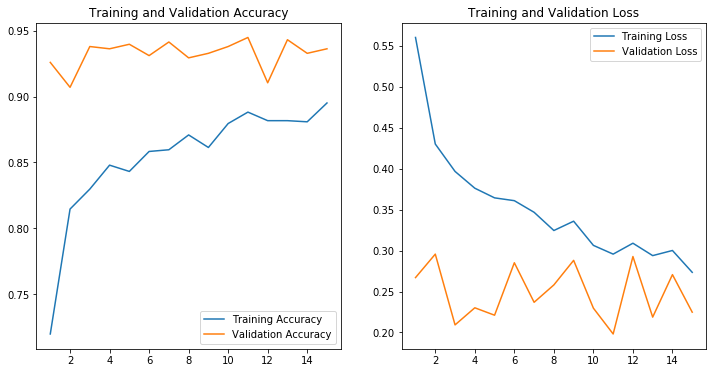

In [34]:
acc = my_history_z3.history['acc']
val_acc = my_history_z3.history['val_acc']

loss = my_history_z3.history['loss']
val_loss = my_history_z3.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# save model and history object
import json

my_model_z3.save('/content/gdrive/My Drive/Colab Notebooks/z3_custom_15_epoch.h5')
my_history_z3_dict = my_history_z3.history
with open('z3_custom_15_epoch_history.txt', 'w') as outfile:  
    json.dump(str(my_history_z3_dict), outfile)

# Zoom Level 4

In [5]:
train_data_gen_z4, val_data_gen_z4, class_weights_z4 = get_image_gen(4)

total_train_z4 = train_data_gen_z4.n
total_val_z4 = val_data_gen_z4.n

Train dir:  data/train/z4
Val dir:  data/val/z4
Found 628 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [0]:
my_model_z4 = Sequential()
my_model_z4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
my_model_z4.add(MaxPooling2D((2, 2)))
my_model_z4.add(Conv2D(64, (3, 3), activation='relu'))
my_model_z4.add(MaxPooling2D((2, 2)))
my_model_z4.add(Conv2D(128, (3, 3), activation='relu'))
my_model_z4.add(MaxPooling2D((2, 2)))
my_model_z4.add(Conv2D(128, (3, 3), activation='relu'))
my_model_z4.add(MaxPooling2D((2, 2)))
my_model_z4.add(Flatten())
# my_model_z4.add(Dense(512, activation='relu'))
my_model_z4.add(Dense(1, activation='sigmoid'))

In [26]:
EPOCHS = 20

my_model_z4.compile(loss='binary_crossentropy', 
                    optimizer='adam', 
                    metrics=['acc'])

# Now is a good time for a cup of coffee
my_history_z4 = my_model_z4.fit_generator(
      train_data_gen_z4,
      steps_per_epoch=int(np.ceil(total_train_z4 / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen_z4,
      validation_steps=int(np.ceil(total_val_z4 / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/20
20/20 - 5s - loss: 0.6760 - acc: 0.6194 - val_loss: 0.4495 - val_acc: 0.8813
Epoch 2/20
20/20 - 3s - loss: 0.6102 - acc: 0.6799 - val_loss: 0.4831 - val_acc: 0.8062
Epoch 3/20
20/20 - 3s - loss: 0.5791 - acc: 0.7357 - val_loss: 0.4361 - val_acc: 0.8750
Epoch 4/20
20/20 - 3s - loss: 0.5465 - acc: 0.7341 - val_loss: 0.4024 - val_acc: 0.8313
Epoch 5/20
20/20 - 3s - loss: 0.5410 - acc: 0.7229 - val_loss: 0.4705 - val_acc: 0.7875
Epoch 6/20
20/20 - 4s - loss: 0.5381 - acc: 0.7548 - val_loss: 0.4006 - val_acc: 0.8313
Epoch 7/20
20/20 - 4s - loss: 0.5157 - acc: 0.7500 - val_loss: 0.4163 - val_acc: 0.8562
Epoch 8/20
20/20 - 4s - loss: 0.5210 - acc: 0.7580 - val_loss: 0.3710 - val_acc: 0.8625
Epoch 9/20
20/20 - 3s - loss: 0.4893 - acc: 0.7580 - val_loss: 0.3606 - val_acc: 0.8562
Epoch 10/20
20/20 - 3s - loss: 0.4934 - acc: 0.7723 - val_loss: 0.4998 - val_acc: 0.8313
Epoch 11/20
20/20 - 3s - loss: 0.4609 - acc: 0.7803 - val_loss: 0.4038 - val_acc: 0.8438
Epoch 12/20
20/20 - 4s - loss:

In [24]:
from sklearn.metrics import classification_report

preds = my_model_z4.predict_generator(val_data_gen_z4, steps = np.ceil(val_data_gen_z4.samples/val_data_gen_z4.batch_size))
pred_class = np.argmax(preds, axis = 1)
true_classes = val_data_gen_z4.classes
class_labels = list(val_data_gen_z4.class_indices.keys())
report = classification_report(true_classes, pred_class, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

    no_tumor       0.88      1.00      0.94       141
       tumor       0.00      0.00      0.00        19

   micro avg       0.88      0.88      0.88       160
   macro avg       0.44      0.50      0.47       160
weighted avg       0.78      0.88      0.83       160



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


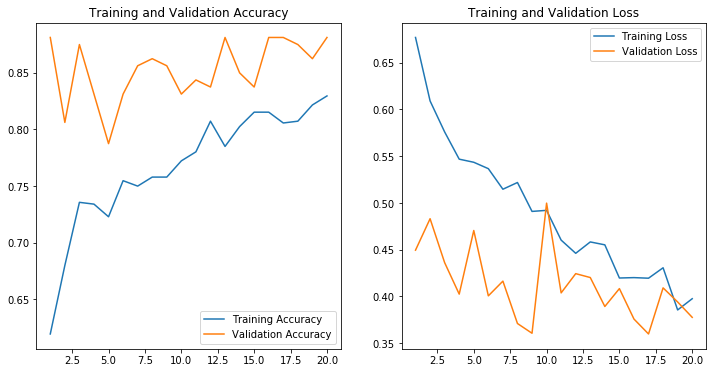

In [27]:
acc = my_history_z4.history['acc']
val_acc = my_history_z4.history['val_acc']

loss = my_history_z4.history['loss']
val_loss = my_history_z4.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Combining 2 Levels - Custom CNN (Zoom 2) and Custom CNN (Zoom 3)

In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [0]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# import skimage
# from skimage.color import rgb2gray
import os
from os import listdir
from os.path import isfile, join
import random 
import cv2
from sklearn.preprocessing import normalize
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Activation, Input, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.utils import *


In [0]:
from tensorflow.keras.models import Model

# define two sets of inputs
inputA = Input(shape=(299, 299, 3))
inputB = Input(shape=(299, 299, 3))

x = Conv2D(32, (3, 3), activation='relu')(inputA)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Model(inputs=inputA, outputs=x)

y = Conv2D(32, (3, 3), activation='relu')(inputB)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(64, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(128, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Conv2D(128, (3, 3), activation='relu')(y)
y = MaxPooling2D((2, 2))(y)
y = Flatten()(y)
y = Model(inputs=inputB, outputs=y)

# combine the output of the two branches
combined = concatenate([x.output, y.output])
 
# # apply a FC layer and then a regression prediction on the combined outputs
z = Dense(2, activation='relu')(combined)
z = Dense(1, activation='sigmoid')(z)
 
# # our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 297, 297, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 297, 297, 32) 896         input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
seed = 1

train_dir_z3 = 'data_zoom/train/z3'
train_dir_z4 = 'data_zoom/train/z4'
val_dir_z3 = 'data_zoom/val/z3'
val_dir_z4 = 'data_zoom/val/z4'

image_gen_train = ImageDataGenerator(rescale=1./255)
image_gen_val = ImageDataGenerator(rescale=1./255)

In [0]:
def generate_generator_multiple(generator,dir1, dir2):
  # combines images from two image generatorsI thiIhi
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (TARGET_SHAPE,TARGET_SHAPE),
                                          class_mode = 'binary',
                                          batch_size = BATCH_SIZE,
                                          shuffle=False, 
                                          seed=7)
    genX2 = generator.flow_from_directory(dir2,
                                          target_size = (TARGET_SHAPE,TARGET_SHAPE),
                                          class_mode = 'binary',
                                          batch_size = BATCH_SIZE,
                                          shuffle=False, 
                                          seed=7)
    while True:
      X1i = genX1.next()
      X2i = genX2.next()
      yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
            

In [0]:
train_gen = generate_generator_multiple(generator=image_gen_train,
                                         dir1=train_dir_z3,
                                         dir2=train_dir_z4)      
     
val_gen = generate_generator_multiple(generator=image_gen_val,
                                      dir1=val_dir_z3,
                                      dir2=val_dir_z4)

In [0]:
EPOCHS = 20

history_multiple = model.fit_generator(train_gen, 
                                       epochs=EPOCHS,
                                       steps_per_epoch=int(np.ceil(48613/ float(BATCH_SIZE))),
                                       validation_data = val_gen,
                                       validation_steps=int(np.ceil(9994/ float(BATCH_SIZE))),
                                       use_multiprocessing=True,
                                       verbose=2)


Epoch 1/20
20/20 - 5s - loss: 0.7874 - acc: 0.6226 - val_loss: 0.4920 - val_acc: 0.8813
Epoch 2/20
20/20 - 5s - loss: 0.6112 - acc: 0.6672 - val_loss: 0.4970 - val_acc: 0.8562
Epoch 3/20
20/20 - 4s - loss: 0.5855 - acc: 0.7134 - val_loss: 0.5038 - val_acc: 0.8250
Epoch 4/20
20/20 - 4s - loss: 0.5571 - acc: 0.7452 - val_loss: 0.3653 - val_acc: 0.8687
Epoch 5/20
20/20 - 4s - loss: 0.6095 - acc: 0.6990 - val_loss: 0.4649 - val_acc: 0.8687
Epoch 6/20
20/20 - 4s - loss: 0.5573 - acc: 0.7468 - val_loss: 0.4787 - val_acc: 0.8125
Epoch 7/20
20/20 - 3s - loss: 0.5469 - acc: 0.7452 - val_loss: 0.4196 - val_acc: 0.8375
Epoch 8/20
20/20 - 4s - loss: 0.5498 - acc: 0.7389 - val_loss: 0.5249 - val_acc: 0.8188
Epoch 9/20
20/20 - 4s - loss: 0.5411 - acc: 0.7468 - val_loss: 0.4577 - val_acc: 0.8000
Epoch 10/20
20/20 - 4s - loss: 0.4952 - acc: 0.7580 - val_loss: 0.3982 - val_acc: 0.8375
Epoch 11/20
20/20 - 4s - loss: 0.5058 - acc: 0.7564 - val_loss: 0.4936 - val_acc: 0.7937
Epoch 12/20
20/20 - 4s - loss:

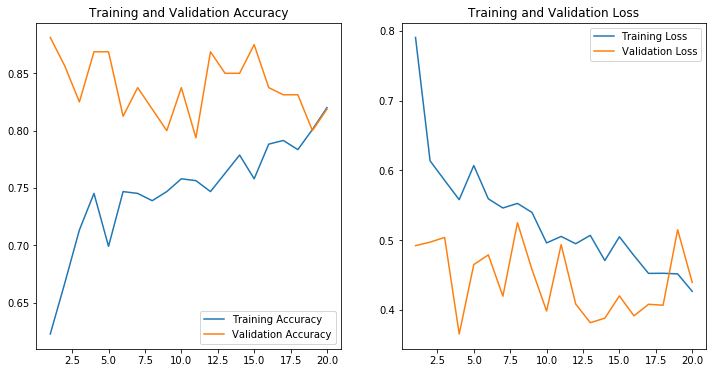

In [0]:
acc = my_history_multiple.history['acc']
val_acc = my_history_multiple.history['val_acc']

loss = my_history_multiple.history['loss']
val_loss = my_history_multiple.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()